# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [260]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [261]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

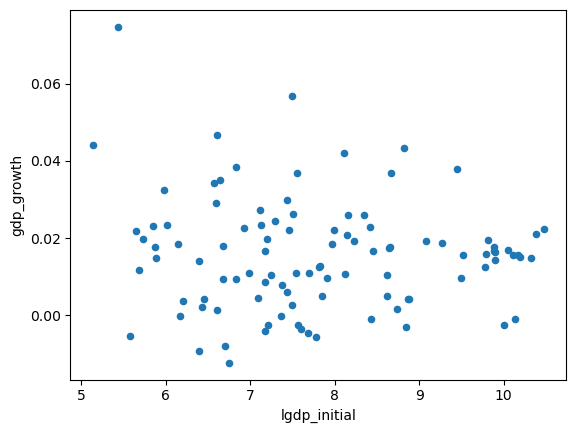

In [262]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

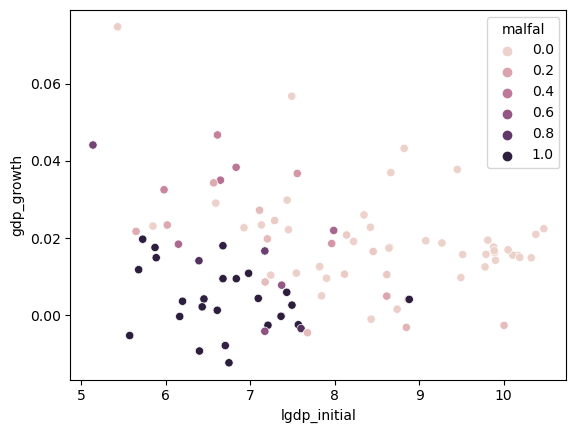

In [263]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [264]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [265]:
dat.isnull().sum() # check for missing values

code                 0
marketref           78
dem                 59
demCGV              64
demBMR              60
                  ... 
investment_rate     35
gdp_growth         112
pop_growth          16
lgdp_initial       105
lpop_initial        15
Length: 85, dtype: int64

# Prepare data

In [266]:
vs = vv_all['geography'] + vv_all['institutions']
xs = ['pop_growth', 'investment_rate', 'yellow', 'malfal'] + vs

# avoiding missings
all_vars = ['gdp_growth', 'lgdp_initial'] + xs
I = dat[all_vars].notnull().all(axis=1)

# extract data
Z_basic = dat.loc[I, xs].values
D = dat.loc[I, 'lgdp_initial']
y = dat.loc[I,'gdp_growth'] * 100. #easier to read output when growth is in 100%

In [267]:
# Add polynomial features. We add interaction terms and quadratic terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
Z = poly.fit_transform(Z_basic)
Z_feature_names = poly.get_feature_names_out(xs)

# Calculate variance for each new term
interaction_variances = np.var(Z, axis=0)

# Filter out interaction terms with zero variance
Z = Z[:, interaction_variances > 0]
Z_feature_names = Z_feature_names[interaction_variances > 0]
Znames = np.array(list(Z_feature_names))

X = np.column_stack((D,Z))
Xnames = np.concatenate((['lgdp_initial'], Znames))

# Display number of regressors
print("The number of regressors in X is {}".format(X.shape[1]))
print("We are left with observations of {} countries".format(X.shape[0]))

The number of regressors in X is 488
We are left with observations of 76 countries


In [268]:
# Create a function for standardizing
def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
D_stan = standardize(D)

n,p = X_stan.shape

Map of variables remaining

In [ ]:
# Define custom colors: Grey for False and a different color for True (e.g., dark blue)
cmap = mcolors.ListedColormap(['grey', 'darkblue'])

# Load world map data from Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column to indicate if a country is retained in the analysis
world['retained'] = world['iso_a3'].isin(retained_countries)

# Plot the map without the default legend
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='retained',  # Color by inclusion status
           cmap=cmap,           # Custom color map
           legend=False,         # Disable default legend
           ax=ax,
           missing_kwds={'color': 'lightgrey', 'label': 'No Data'})  # Light grey for countries not in dataset

# Create custom legend entries
retained_patch = mpatches.Patch(color='darkblue', label='Countries Retained')
excluded_patch = mpatches.Patch(color='grey', label='Countries Excluded')

# Add custom legend with descriptive labels
plt.legend(handles=[retained_patch, excluded_patch], loc='upper left')

# Add title and other formatting
ax.set_title("Countries Retained in Analysis After Data Preparation", fontsize=16)
ax.set_axis_off()

# Display the map
plt.show()

### Penalities

#### BCCH

In [269]:
# BCCH penalty:
def BCCH(X_stan,y):
    n,p = X_stan.shape
    c = 1.1
    alpha = 0.05
    yXscale = (np.max((X_stan.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale

    # Pilot estimates
    pred = Lasso(alpha=penalty_pilot).fit(X_stan,y).predict(X_stan)

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_stan.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)

    return penalty_BCCH


#### CV

In [270]:
# CV penalty:
def CV(X_stan,y):
    fit_CV = LassoCV(cv=5).fit(X_stan,y)

    # Investigate the penalty
    penalty_CV = fit_CV.alpha_

    return penalty_CV

## POST DOUBLE LASSO

### PDL BCCH penalty

Step 1: Lasso Y using D and Z 

In [271]:
# Calculate BRT
penalty_BCCHyx = BCCH(X_stan, y)
print("lambda_BCCHyx =",penalty_BCCHyx.round(3))

# Run Lasso 
fit_BCCHyx = Lasso(penalty_BCCHyx, max_iter=10000).fit(X_stan, y)
coefs=fit_BCCHyx.coef_

# Calculate residuals
resyx = y-fit_BCCHyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

# Count non-zero coefficients
print("The number of non-zero coefficients in the first stage is =", np.count_nonzero(coefs))

lambda_BCCHyx = 2.623
The number of non-zero coefficients in the first stage is = 0


Step 2: Lasso D using Z

In [272]:
penalty_BCCHdz = BCCH(Z_stan, D)
print("lambda_BCCHdz =",penalty_BCCHdz.round(3))

# Run Lasso
fit_BCCHdz = Lasso(penalty_BCCHdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_BCCHdz.coef_

# Calculate residuals
resdz=D-fit_BCCHdz.predict(Z_stan)

# Count non-zero coefficients
print("The number of non-zero coefficients in the second stage is =", np.count_nonzero(coefs))

lambda_BCCHdz = 1.127
The number of non-zero coefficients in the second stage is = 0


Step 3: Estimate beta

In [273]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
beta_PDL = num/denom

# Display alpha
print("beta_PDL = ",beta_PDL.round(3))

beta_PDL =  -0.132


Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\beta}$.

In [274]:
# Calculate the implied variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(3))

sigma2_PDL =  1.399


In [275]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/n)

# Display standard error
print("se_PDL = ",se_PDL.round(3))

se_PDL =  0.136


In [276]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = beta_PDL - q * se_PDL
CI_high_PDL = beta_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(3),CI_high_PDL.round(3)))

CI_PDL =  (-0.398, 0.133)


### PDL CV Penalty

In [277]:
# Calculate CV penalty
penalty_CVyx = CV(X_stan, y)
print("lambda_CVyx =",penalty_CVyx.round(3))

# Run Lasso 
fit_CVyx = Lasso(penalty_CVyx, max_iter=10000).fit(X_stan, y)
coefs=fit_CVyx.coef_

# Calculate residuals
resyx = y-fit_CVyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

# Count non-zero coefficients
print("The number of non-zero coefficients in the first stage is =", np.count_nonzero(coefs))

# Investigate the selected variables
selected_variables = (coefs!=0)
selected_variable_names = Xnames[selected_variables].tolist()
print('Selected variables:', selected_variable_names)

/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-02, tolerance: 1.089e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e-02, tolerance: 1.089e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

lambda_CVyx = 0.092
The number of non-zero coefficients in the first stage is = 19
Selected variables: ['lgdp_initial', 'investment_rate', 'pop_growth^2', 'pop_growth suitgini', 'pop_growth demCGV', 'investment_rate demCGV', 'investment_rate demBMR', 'malfal abslat', 'malfal demreg', 'distr temp', 'suitavg cenlong', 'temp elevavg', 'elevavg marketref', 'elevstd area', 'precip abslat', 'precip africa', 'area cenlong', 'cenlong asia', 'rough demCGV']


Step 2: Lasso D using Z

In [278]:
penalty_CVdz = CV(Z_stan, D)
print("lambda_CVdz =",penalty_CVdz.round(3))

# Run Lasso
fit_CVdz = Lasso(penalty_CVdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_CVdz.coef_

# Calculate residuals
resdz=D-fit_CVdz.predict(Z_stan)

# Count non-zero coefficients
print("The number of non-zero coefficients in the second stage is =", np.count_nonzero(coefs))

# Investigate the selected variables
selected_variables = (coefs!=0)
selected_variable_names = Znames[selected_variables].tolist()
print('Selected variables:', selected_variable_names)

/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-02, tolerance: 1.123e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e-02, tolerance: 1.123e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

lambda_CVdz = 0.057
The number of non-zero coefficients in the second stage is = 31
Selected variables: ['investment_rate', 'pop_growth area', 'pop_growth asia', 'investment_rate demreg', 'yellow suitavg', 'yellow asia', 'malfal suitavg', 'malfal elevstd', 'malfal abslat', 'malfal rough', 'tropicar suitavg', 'distr abslat', 'distcr suitavg', 'distcr elevstd', 'distc suitavg', 'distc asia', 'suitavg asia', 'temp landlock', 'temp africa', 'elevstd^2', 'kgatr abslat', 'area marketref', 'abslat africa', 'abslat marketref', 'abslat dem', 'abslat demCGV', 'abslat demreg', 'cenlong asia', 'cenlong demreg', 'area_ar asia', 'marketref demreg']


Step 3: Estimate beta

In [279]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
beta_PDL = num/denom

# Display alpha
print("beta_PDL = ",beta_PDL.round(3))

beta_PDL =  -0.668


Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\alpha}$.

In [280]:
# Calculate variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(3))

sigma2_PDL =  2.901


In [281]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/n)

# Display standard error
print("se_PDL = ",se_PDL.round(3))

se_PDL =  0.195


In [282]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = beta_PDL - q * se_PDL
CI_high_PDL = beta_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(3)))

CI_PDL =  (-1.05, -0.285)


Consider the path of mean squared errors (MSE) for different penalty levels. Plot the mean MSE across folds as a function of the penalty level.

In [283]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 1, num = 50)

coefs=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_stan,y) 
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e-02, tolerance: 1.568e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e-02, tolerance: 1.568e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

In [284]:
# Estimate the model using LassoCV
fit_CV = LassoCV(cv=5, alphas=penalty_grid).fit(X_stan,y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_ 
print('Penalty_CV: ', round(penalty_CV,4))

# Retrieve penalty and MSE
penalties_CV = fit_CV.alphas_
MSE_CV = np.mean(fit_CV.mse_path_, axis=1)

/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e-02, tolerance: 1.011e-02
  model = cd_fast.enet_coordinate_descent(
/Users/claraengelund/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e-02, tolerance: 1.011e-02
  model = cd_fast.enet_coordinate_descent(


Penalty_CV:  0.0869


In [285]:
# Define a function that plots the MSE as a function of the penalty parameter

def plot_MSE_path(penalty_grid, MSE):
    """
    Plots the mean squared error (MSE) as a function of the penalty parameter.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    MSE (array-like): The corresponding MSE values.

    """
    # Initiate figure 
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot MSE as a function of the penalty parameter
    ax.plot(penalty_grid, MSE)

    # Set log scale for the x-axis
    ax.set_xscale('log')
    
    # Plot minimum MSE
    min_MSE_idx = np.argmin(MSE)
    min_MSE_penalty = penalty_grid[min_MSE_idx]
    min_MSE_value = MSE[min_MSE_idx]
    ax.axvline(x=min_MSE_penalty, linestyle='--', color='grey')
    
    # Position the "Minimum MSE" text within plot bounds
    y_text_position = min(min_MSE_value * 1.1, max(MSE) * 0.9)  # 10% above the minimum MSE or below max MSE
    ax.text(min_MSE_penalty, y_text_position, "Minimum MSE", rotation=90, verticalalignment='bottom')


    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel('Mean squared error')
    plt.title('Mean squared error')

    # Display plot
    plt.show()
    plt.close()

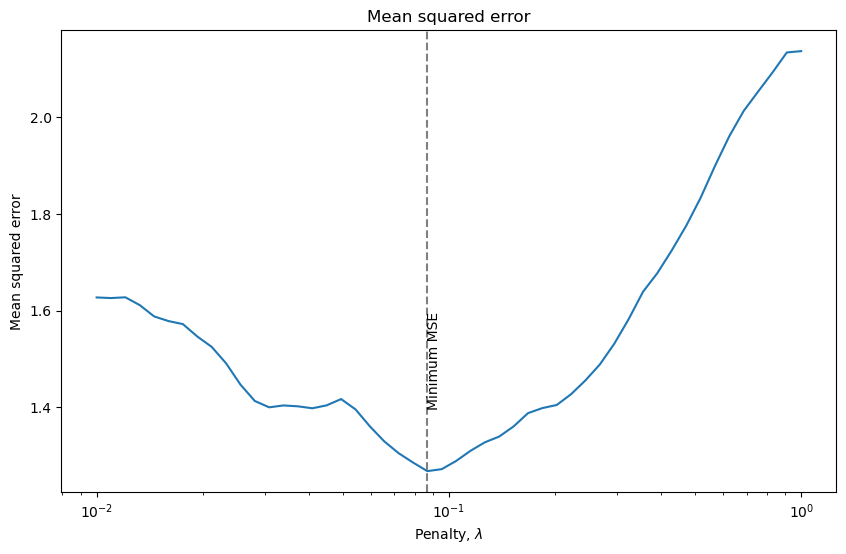

In [286]:
# Plot MSE as a function of the penalty parameter
plot_MSE_path(penalties_CV, MSE_CV)